In [1]:
data_path='C:\AnatArzData\Data\ica_interpolated'
data_path1='C:\AnatArzData\Data\RDMs_and_distances_results'
data_path2='C:\AnatArzData\Data\EEG_data_for_analysis'


import numpy as np
import os
import mne
from mne import io
from tqdm import tqdm
import gc
import matplotlib
import matplotlib.pyplot as plt

In [4]:
subj_id = '32'

In [6]:
subject_setfile_sleep = data_path + '/s_' + subj_id + '_sleep_int.set'
epochs_w_ngt_currSub = io.read_epochs_eeglab(subject_setfile_sleep, events=None, event_id=None,  eog=(),verbose=None, uint16_codec=None)

Extracting parameters from C:\AnatArzData\Data\ica_interpolated\s_32_sleep_int.set...


C:\Users\Sharon\AppData\Local\Temp\ipykernel_2108\3989805243.py:2: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  epochs_w_ngt_currSub = io.read_epochs_eeglab(subject_setfile_sleep, events=None, event_id=None,  eog=(),verbose=None, uint16_codec=None)


Not setting metadata
25184 matching events found
No baseline correction applied
0 projection items activated
Ready.


In [8]:
alltrialnum_eeglabepochs_list = []

alltrialnum_eeglabepochs_list.append(epochs_w_ngt_currSub['N2T1098_1'])
alltrialnum_eeglabepochs_list.append(epochs_w_ngt_currSub['N2T1098_2'])
alltrialnum_eeglabepochs_list.append(epochs_w_ngt_currSub['N2T1098_3'])
alltrialnum_eeglabepochs_list.append(epochs_w_ngt_currSub['N2T1098_4'])

In [9]:
alltrialnum_epochs_list = mne.concatenate_epochs(alltrialnum_eeglabepochs_list)

Not setting metadata
250 matching events found
No baseline correction applied
0 bad epochs dropped


In [10]:
evoked = alltrialnum_epochs_list.average()

## Multiple conditions

In [1]:
%reset -f

data_path='C:\AnatArzData\Data\ica_interpolated'
data_path1='C:\AnatArzData\Data\RDMs_and_distances_results'
data_path2='C:\AnatArzData\Data\EEG_data_for_analysis'


import numpy as np
import os
import mne
from mne import io
import pickle
import joblib
from tqdm import tqdm
import gc
import matplotlib
import matplotlib.pyplot as plt
import logging, sys
logging.disable(sys.maxsize)

In [28]:
all_subjs = ['8','9','10','11','12','13','14','15','16','17','19','20','21','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37','38']

all_good_subjects = ['32','35','36','37','38']
all_wake_data_subjects = ['32','33','34','35','38']

list1_as_set = set(all_good_subjects)
intersection = list1_as_set.intersection(all_wake_data_subjects)
all_goodAndGotWakeData_subjects = list(intersection)

toneHieghts = ['650','845','1098','1428','1856','2413','3137','4079','5302']
toneTypes = ['O','T'] # There are A/O/T

sleepstages = ['N2', 'N3', 'Rp', 'Rt']
wakestages = ['Wn']
vigelenceStages = np.concatenate((sleepstages,wakestages))

trialNums = [6,7,8,9]

In [36]:
## import all data to dictionary with events name
def import_data(subs, toneHieghts, toneTypes, sleepstages,wakestages,trialNums):
    alldata_epochs = {}
    alldata_evoked = {}
    for sub_i, sub in tqdm(enumerate(subs)):
        ## evacuate memo
        gc.collect()
        try: del currSub_eeglabEpochs
        except NameError: pass

        ## sleep: get eeglabEpochs for a subject
        try:
            subject_setfile_sleep = data_path + '/s_' + sub + '_sleep_int.set'
            currSub_eeglabEpochs = io.read_epochs_eeglab(subject_setfile_sleep, events=None, event_id=None,  eog=(),verbose=None, uint16_codec=None)
        except FileNotFoundError: continue
        ## arrange all epochs in an dict
        for ss_i, ss in enumerate(sleepstages):
            for toneHi_i, toneHi in enumerate(toneHieghts):
                for toneTy_i, toneTy in enumerate(toneTypes):
                    for trial_i, trial in enumerate(trialNums):
                        try:
                            trial_name = f"{ss}{toneTy}{toneHi}_{trial}"
                            currTrial_eeglabEpoch = currSub_eeglabEpochs[trial_name]
                            currTrial_eeglabEpoch = currTrial_eeglabEpoch.set_eeg_reference(ref_channels='average')
                            currTrial_mneEpoch = mne.concatenate_epochs([currTrial_eeglabEpoch])
                            alldata_epochs[f"s{sub}_{trial_name}"] = currTrial_mneEpoch
                            alldata_evoked[f"s{sub}_{trial_name}"] = currTrial_mneEpoch.average()
                        except KeyError: continue

        ## evacuate memo
        gc.collect()
        try: del currSub_eeglabEpochs
        except NameError: pass
        ## Wake: get eeglabEpochs for a subject
        try:
            subject_setfile_wake = data_path + '/s_' + sub + '_wake_night_int.set'
            currSub_eeglabEpochs = io.read_epochs_eeglab(subject_setfile_wake, events=None, event_id=None,  eog=(),verbose=None, uint16_codec=None)
        except FileNotFoundError: continue
        ## arrange all epochs in an dict
        for ws_i, ws in enumerate(wakestages):
            for toneHi_i, toneHi in enumerate(toneHieghts):
                for toneTy_i, toneTy in enumerate(toneTypes):
                    for trial_i, trial in enumerate(trialNums):
                        try:
                            if ws == 'Wn':
                                ws_name = ''
                            else:
                                ws_name = ws
                            trial_name = f"{ws_name}{toneTy}{toneHi}_{trial}"
                            currTrial_eeglabEpoch = currSub_eeglabEpochs[trial_name]
                            currTrial_eeglabEpoch = currTrial_eeglabEpoch.set_eeg_reference(ref_channels='average')
                            currTrial_mneEpoch = mne.concatenate_epochs([currTrial_eeglabEpoch])
                            alldata_epochs[f"s{sub}_{ws}{trial_name}"] = currTrial_mneEpoch
                            alldata_evoked[f"s{sub}_{ws}{trial_name}"] = currTrial_mneEpoch.average()
                        except KeyError: continue
    return  alldata_epochs, alldata_evoked

alldata_epochs, alldata_evoked = import_data(all_goodAndGotWakeData_subjects, toneHieghts, toneTypes, sleepstages,wakestages,trialNums)

0it [00:00, ?it/s]C:\Users\Sharon\AppData\Local\Temp\ipykernel_21212\3144080131.py:14: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  currSub_eeglabEpochs = io.read_epochs_eeglab(subject_setfile_sleep, events=None, event_id=None,  eog=(),verbose=None, uint16_codec=None)
C:\Users\Sharon\AppData\Local\Temp\ipykernel_21212\3144080131.py:37: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  currSub_eeglabEpochs = io.read_epochs_eeglab(subject_setfile_wake, events=None, event_id=None,  eog=(),verbose=None, uint16_codec=None)
1it [01:58, 118.37s/it]C:\Users\Sharon\AppData\Local\Temp\ipykernel_21212\3144080131.py:14: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  currSub_eeglabEpochs = io.read_epochs_eeglab(subject_setfile_sleep, events=None, event_id=None,  eog=(),verbose=None, uint16_codec=None)
C:\Users\Sharon\AppData\Local\Temp\ipykernel_21212\3144080131.py:37: RuntimeWarning: Unknown types found, setting as type EEG:

In [37]:
SoVs = vigelenceStages
subjects = all_wake_data_subjects
epochsData = alldata_epochs

## get specific epochs to plot state of vigilance, with errors for subject
SoVs_EpochsList = []
sub_list = []
for ss_i, ss in tqdm(enumerate(SoVs)):
    curr_ss =[]
    for sub_i, sub in enumerate(subjects):
        curr_sub =[]
        for toneHi_i, toneHi in enumerate(toneHieghts):
            for toneTy_i, toneTy in enumerate(toneTypes):
                for trial_i, trial in enumerate(trialNums):
                    try:
                        trial_name = f"s{sub}_{ss}{toneTy}{toneHi}_{trial}"
                        curr_sub.append(epochsData[trial_name])
                    except KeyError:
                        continue
        if not curr_sub==[]:
            curr_ss.append(curr_sub)
            sub_list.append(sub)
    SoVs_EpochsList.append(curr_ss)

## compute evoke for each state of vigilance and subject and arrange in dict to display
sovs_evoked_dict = {}
for ss_i, ss in tqdm(enumerate(SoVs)):
    curr_evoked_ss = []
    for sub_i, sub in enumerate(subjects):
        try:
            curr_concatEpochs_sub = mne.concatenate_epochs(SoVs_EpochsList[ss_i][sub_i])
        except IndexError:
            continue
        curr_evoked_sub = curr_concatEpochs_sub.average()
        curr_evoked_ss.append(curr_evoked_sub)
    sovs_evoked_dict[ss] = curr_evoked_ss

5it [00:00, 918.64it/s]
5it [00:43,  8.76s/it]


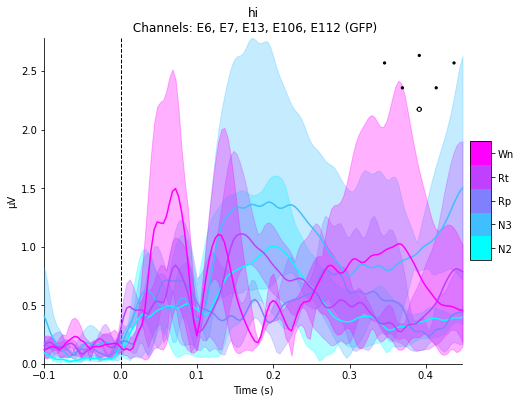

[<Figure size 576x432 with 3 Axes>]

In [38]:
## plot
electrodes=[4,5,10,79,84]
cmap = 'cool'           # more color options: https://matplotlib.org/3.5.0/tutorials/colors/colormaps.html
mne.viz.plot_compare_evokeds(sovs_evoked_dict,picks=electrodes, cmap=cmap,
                             truncate_xaxis=False, truncate_yaxis=False, split_legend=True, #show_legend='upper left',
                             show_sensors='upper right', show=True,
                             title= f"hi\n Channels: E6, E7, E13, E106, E112",)

In [39]:
# saving evoked
filename = 'C:\AnatArzData\Data\\subs_evoked'
joblib.dump(alldata_evoked, filename)
#alldata_evoked = joblib.load(filename)

['C:\\AnatArzData\\Data\\subs_evoked']

## Working with dict of evokeds

In [50]:
def plot_(dict,title=''):
    electrodes=[4,5,10,79,84]
    cmap = 'cool'           # more color options: https://matplotlib.org/3.5.0/tutorials/colors/colormaps.html
    mne.viz.plot_compare_evokeds(dict,picks=electrodes, cmap=cmap,
                                 truncate_xaxis=False, truncate_yaxis=False, split_legend=True, #show_legend='upper left',
                                 show_sensors='upper right', show=True,
                                 title= f"{title}\n Channels: E6, E7, E13, E106, E112",)

In [48]:
SoVs = vigelenceStages
subjects = all_wake_data_subjects
alldata_evoked = alldata_evoked

## get specific epochs to plot sleep stage, with errors for subject
sovs_evoked_dict = {}
for ss_i, ss in tqdm(enumerate(SoVs)):
    curr_sov =[]
    for sub_i, sub in enumerate(subjects):
        curr_sub =[]
        for toneHi_i, toneHi in enumerate(toneHieghts):
            for toneTy_i, toneTy in enumerate(toneTypes):
                for trial_i, trial in enumerate(trialNums):
                    try:
                        trial_name = f"s{sub}_{ss}{toneTy}{toneHi}_{trial}"
                        curr_sub.append(alldata_evoked[trial_name])
                    except KeyError:
                        continue
        if not curr_sub == []:
            sub_list.append(sub)
            average_sub_evoked = mne.grand_average(curr_sub)
            curr_sov.append(average_sub_evoked)
    sovs_evoked_dict[ss] = curr_sov

5it [00:02,  1.69it/s]


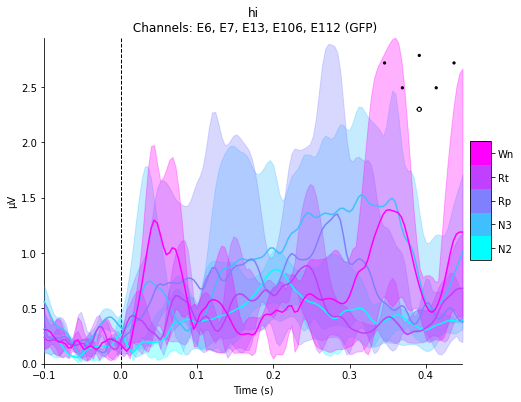

In [49]:
plot_(sovs_evoked_dict)